In [81]:
import mysql.connector as mariadb
import pandas as pd
import pandas.io.sql as psql
from dotenv import load_dotenv
import os
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

load_dotenv()

import re
import pdb

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Martin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Connect to Database

In [198]:
db=mariadb.connect(
    host=os.getenv("DB_HOST"),
    user=os.getenv("DB_USER"),
    passwd=os.getenv("DB_PASS"),
    db=os.getenv("DB_NAME"))
query = "select title, body, date from {}".format(os.getenv("DB_TABLE_NAME"))
forum_titles_frame = psql.read_sql(query, con=db)
db.close()

### Data content and shape

In [199]:
forum_titles_frame.head()

,title,body,date
0,ayuda con fluidos no newtonianos,"hola a todos, una amiga necesita ayuda con un ...",2020-06-07 00:00:00
1,¿cómo recuperar la motivación para trabajar?,"dentro de esta etapa de confinamiento, donde s...",2020-06-07 00:00:00
2,[invitación] forma parte de un proyecto abiert...,hola compañeros y compañeras!!\njunto con un g...,2020-06-08 23:02:22
3,template latex,"hola, ya que el thread anterior se llenó, publ...",2020-06-04 00:00:00
4,ley que fortalece el sistema de inteligencia n...,de seguro algunos han visto algún artículo que...,2020-06-06 00:00:00


In [200]:
# pdb.set_trace()
forum_titles_frame.shape

(91995, 3)

In [201]:
forum_titles_frame.index

RangeIndex(start=0, stop=91995, step=1)

#### Map datestamp to year

In [202]:
titles_frame_mappedYear = forum_titles_frame[['date']].apply(lambda datestamp: datestamp.dt.year)
titles_frame_mappedYear[['title', 'body']] = forum_titles_frame[['title', 'body']]
titles_frame_mappedYear.head()

,date,title,body
0,2020,ayuda con fluidos no newtonianos,"hola a todos, una amiga necesita ayuda con un ..."
1,2020,¿cómo recuperar la motivación para trabajar?,"dentro de esta etapa de confinamiento, donde s..."
2,2020,[invitación] forma parte de un proyecto abiert...,hola compañeros y compañeras!!\njunto con un g...
3,2020,template latex,"hola, ya que el thread anterior se llenó, publ..."
4,2020,ley que fortalece el sistema de inteligencia n...,de seguro algunos han visto algún artículo que...


### Threads count per year

In [203]:
titles_frame_mappedYear_only_title = titles_frame_mappedYear[['date', 'title']]
titles_frame_mappedYear_only_title.groupby(['date']).count().loc[2011]

title    15503
Name: 2011, dtype: int64

In [204]:
count_titles = titles_frame_mappedYear_only_title.groupby(['date']).count()
count_titles.index

Int64Index([2002, 2003, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,
            2015, 2016, 2017, 2018, 2019, 2020],
           dtype='int64', name='date')

In [205]:
selected_years_mask = [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
#count_titles.loc[(count_titles.index > 2008) & (count_titles.index < 2020)]
count_titles.columns = ['thread_count']
count_titles.index.name = 'year'
last_decade_titles_count = count_titles.loc[count_titles.index * selected_years_mask > 0]
last_decade_titles_count

,thread_count
year,
2009,9874
2010,11322
2011,15503
2012,11256
2013,8833
2014,6194
2015,6484
2016,5652
2017,5386


### Word clouds: total and yearly

#### Lemmatizer and Stopwords

In [206]:
resource_file = 'lemmatization-es.txt'
lemmatiser_es = lemmatiser(create_lemma_dict(resource_file))

In [207]:
stopwords_from_file = np.genfromtxt('stopwords_es.txt', dtype='str', delimiter='\n', encoding='utf-8')
stopwords_from_file = formatStrings(pd.Series(stopwords_from_file))

stopwords_es = stopwords.words('spanish') 
stopwords_es = set.union(set(map(cleanSingleString, stopwords_es)), stopwords_from_file)

#### Merge two columns, clean text and remove stop words

In [233]:
mergedTitlesAndBodyCleaned = pd.DataFrame(columns=['titleAndText', 'year'])
mergedTitlesAndBodyCleaned['titleAndText'] = formatStrings(forum_titles_frame["title"] + " " + forum_titles_frame["body"]).transform(lambda text: removeStopWordsFromText(stopwords_es, text))
mergedTitlesAndBodyCleaned['year'] = titles_frame_mappedYear_only_title['date']
mergedTitlesAndBodyCleaned.head()

,titleAndText,year
0,ayuda fluidos newtonianos amiga necesita ayuda...,2020
1,como recuperar motivacion etapa confinamiento ...,2020
2,invitacion forma proyecto abierto cei 2020 com...,2020
3,template latex thread lleno publico enlaces us...,2020
4,ley fortalece sistema inteligencia nacional se...,2020


In [209]:
onlyTitlesCleaned =pd.DataFrame(columns=['title', 'year'])
onlyTitlesCleaned['title'] = formatStrings(forum_titles_frame["title"]).transform(lambda text: removeStopWordsFromText(stopwords_es, text))
onlyTitlesCleaned['year'] = titles_frame_mappedYear_only_title['date']
onlyTitlesCleaned.head()

,title,year
0,ayuda fluidos newtonianos,2020
1,como recuperar motivacion trabajar,2020
2,invitacion forma proyecto abierto cei 2020,2020
3,template latex,2020
4,ley fortalece sistema inteligencia nacional,2020


#### Only titles vs titles and body message

In [211]:
mergedTitlesAndBody = " ".join(mergedTitlesAndBodyCleaned['titleAndText'])
onlyTitles = " ".join(onlyTitlesCleaned['title'])
mergedTitlesAndBody[0:200]

'ayuda fluidos newtonianos amiga necesita ayuda tema fluidos newtonianos juicio tema basico calcular velocidad radial tubo pitot comunicar correo bvasquez1302gmailcom gracias como recuperar motivacion '

#### Total word cloud: merged titles and body

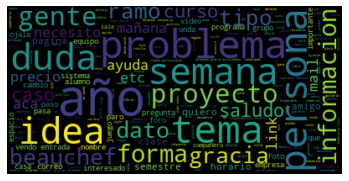

In [213]:
plotWordCloud(mergedTitlesAndBody)

#### Total word cloud: only titles

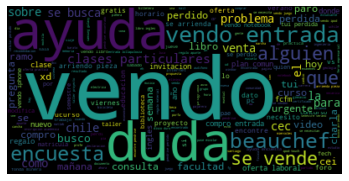

In [214]:
plotWordCloud(onlyTitles)

#### Yearly word clouds

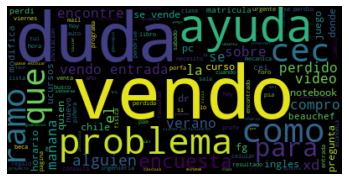

Year: 2009, titles only


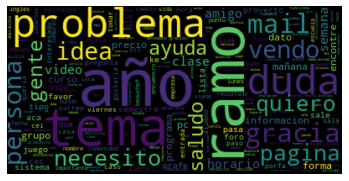

Year: 2009, titles and body


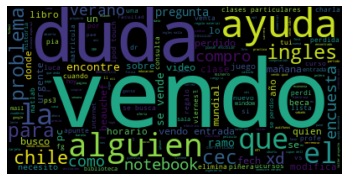

Year: 2010, titles only


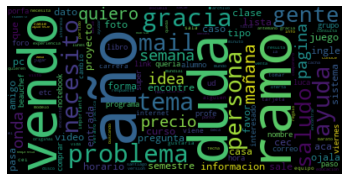

Year: 2010, titles and body


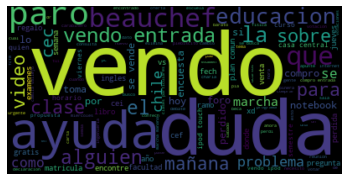

Year: 2011, titles only


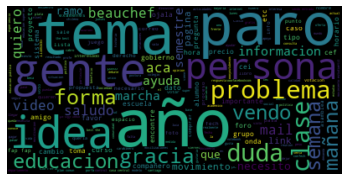

Year: 2011, titles and body


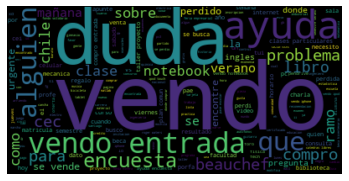

Year: 2012, titles only


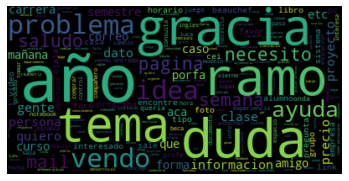

Year: 2012, titles and body


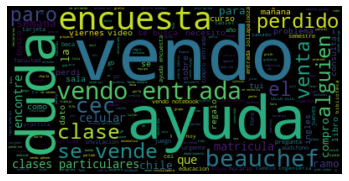

Year: 2013, titles only


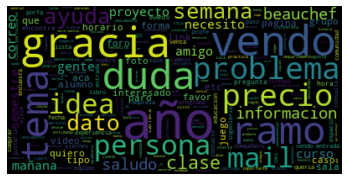

Year: 2013, titles and body


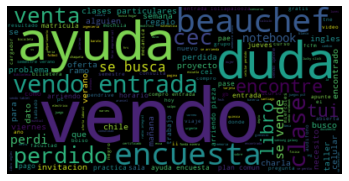

Year: 2014, titles only


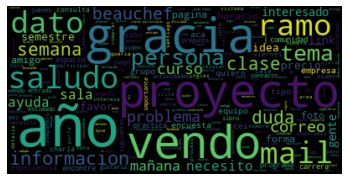

Year: 2014, titles and body


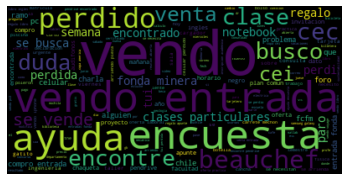

Year: 2015, titles only


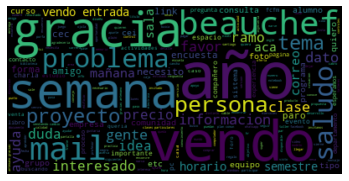

Year: 2015, titles and body


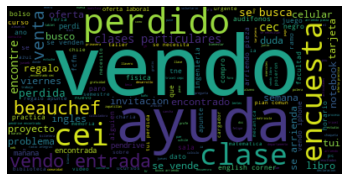

Year: 2016, titles only


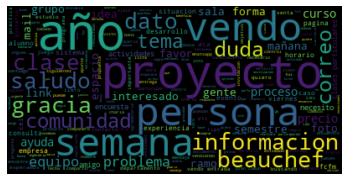

Year: 2016, titles and body


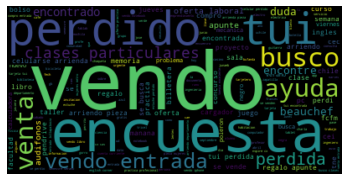

Year: 2017, titles only


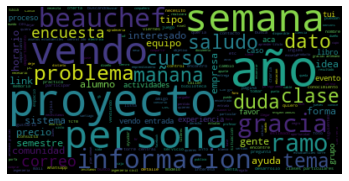

Year: 2017, titles and body


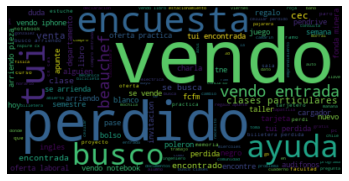

Year: 2018, titles only


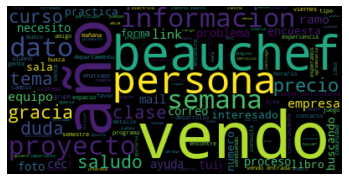

Year: 2018, titles and body


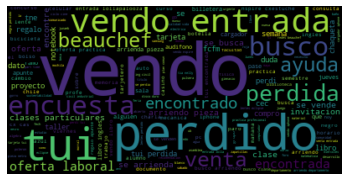

Year: 2019, titles only


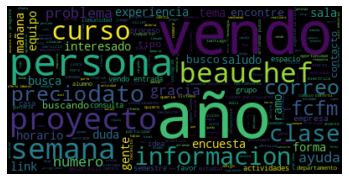

Year: 2019, titles and body


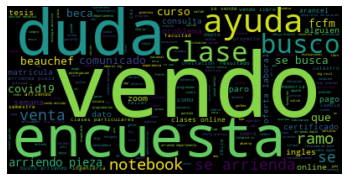

Year: 2020, titles only


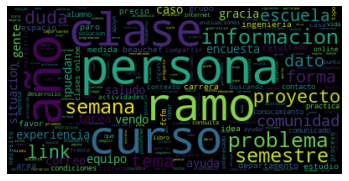

Year: 2020, titles and body


In [216]:
for year in last_decade_titles_count.index:
    titles_from_year = onlyTitlesCleaned[onlyTitlesCleaned['year'] == year]
    mergedText = " ".join(titles_from_year["title"])
    plotWordCloud(mergedText)
    print("Year: {}, titles only".format(year))
    mergedTitleTextFromYear = mergedTitlesAndBodyCleaned[mergedTitlesAndBodyCleaned['year'] == year]
    mergedWithBody = " ".join(mergedTitleTextFromYear['titleAndText'])
    plotWordCloud(mergedWithBody)
    print("Year: {}, titles and body".format(year))

### Threads about mental health

#### init lemmatizer

In [227]:
mental_health_keywords = ['ansiedad', 'desmotivación', 'estres', 'concentracion', 'deprimido', 'depresion',
                             'animo', 'psicologica', 'mental', 'siquiatra', 'psicóloga', 'autocuidado',
                             'bienestar', 'frustración', 'concentrarme', 'motivacion']
mental_health_lemmas = set(map(lemmatiser_es, map(cleanSingleString, mental_health_keywords)))
mental_health_lemmas

{'animo',
 'ansiedad',
 'autocuidado',
 'bienestar',
 'concentracion',
 'concentrar',
 'depresion',
 'deprimir',
 'desmotivacion',
 'estres',
 'frustrar',
 'mental',
 'motivacion',
 'psicologia',
 'siquiatra'}

In [230]:
def lemmatizeSentence(sentence):
    return sentence.transform(lambda sentenceStr: " ".join(map(lemmatiser_es, sentenceStr.split(" "))))

def isTopicOfInterest(sentenceSeries):
    return sentenceSeries.transform(lambda sentence: 1 if any(map(lambda word: word in mental_health_lemmas, sentence.split(" "))) else 0)


textClassified = mergedTitlesAndBodyCleaned[['titleAndText']].apply(lemmatizeSentence).apply(isTopicOfInterest)
textClassified[['year']] = mergedTitlesAndBodyCleaned[['year']]
textClassified.head()

,titleAndText,year
0,0,2020
1,1,2020
2,1,2020
3,0,2020
4,0,2020


In [234]:
textClassifiedGrouped = textClassified.groupby(['year']).sum()
textClassifiedGrouped.loc[textClassifiedGrouped.index * selected_years_mask > 0]

,titleAndText
year,
2009,132
2010,129
2011,257
2012,200
2013,145
2014,94
2015,112
2016,130
2017,108


In [94]:
def formatStrings(strings):

    strings = strings.transform(cleanSingleString)

    # todo a minusculas
    strings = pd.Series(list(map(lambda x: x.lower(), strings)))
    
    return strings

def cleanSingleString(word):
    tildes = ['á','é','í','ó','ú']
    vocales = ['a','e','i','o','u']

    # tildes
    for idx, vocal in enumerate(vocales):
        word = word.replace(tildes[idx],vocal)

    # borrar caracteres especiales menos la ñ
    return re.sub('[^A-Zña-z0-9 ]+', '', word)

In [95]:
def obtainMergedStringsFromSeries(dataSeries):
    return " ".join(dataSeries)

In [96]:
def formatAndMergeStringsFromSeries(dataSeries):
    return obtainMergedStringsFromSeries(formatStrings(dataSeries))

In [212]:
def plotWordCloud(text):
    wordcloud = WordCloud().generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [98]:
def lemmatiser(dict):
    def lookup(word):
        try:
            lemma = dict[word]
        except:
            lemma = word
        
        return lemma
    
    return lookup

In [99]:
def create_lemma_dict(filename):
   with open(filename, 'r', encoding="utf-8") as document:
       lemma_dict = {}
       for line in document:
           if line.strip():  # avoid empty lines
               value, key = line.split(None, 1) # 'None' means 'all whitespace', which is the default
               key = cleanSingleString(key.rstrip()) # rstrip() to get rid of \r and \n
               value = cleanSingleString(value)
               lemma_dict[key] = value # adding the flections as keys to the dict
               lemma_dict[value] = value # adding also the base word as a key
   return lemma_dict

In [130]:
def removeStopWordsFromText(stopwords, text):
    for stopword in stopwords:
        text = text.replace(" {} ".format(stopword), " ")
    
    return text